In [1]:
# model class 

import torch 
from torch import nn 
from tqdm.auto import tqdm 

import json
from importlib import reload

import torch
import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score


class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, nclasses, class_weigths=None, device='cpu') -> None:
        super().__init__()

        # self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim).to(device)
        self.lstm_model = nn.LSTM(embedding_dim, hidden_size//2, bidirectional=True).to(device)
        self.ffwd_lay = nn.Linear(hidden_size, nclasses).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.criterion = nn.CrossEntropyLoss(weight=class_weigths)
        
        self.loss_history = []


    def forward(self, batch):
        # out = self.embedding(batch) # L x vocab_size -> L x embedding_dim
        out = self.lstm_model(batch)[0] # L x hidden_size
        out = self.ffwd_lay(out) # L x nclasses
        return self.softmax(out)


    def fit(self, train_X, train_Y, valid_X, valid_Y, nepochs, lr, device):
        self.train()
        self.to(device)

        for g in self.optim.param_groups:
            g['lr'] = lr    
        
        for ep in tqdm(range(nepochs)):
            eploss = 0

            for batch_X, batch_Y in zip(train_X, train_Y):
                predict = self.forward(batch_X.to(device))
                
                self.optim.zero_grad()
                loss = self.criterion(predict, batch_Y.to(device))
                loss.backward()
                self.optim.step()

                eploss += loss.item()
                self.loss_history.append(loss.item())
            
            printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            if printbool:
                with torch.no_grad():
                    train_predict = []
                    for batch_X in train_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        train_predict.append(predict.cpu())
                    
                    train_predict = torch.cat(train_predict)
                    train_real = torch.cat(train_Y)
    
                    test_predict = []
                    for batch_X in valid_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        test_predict.append(predict.cpu())
                    
                    test_predict = torch.cat(test_predict)
                    test_real = torch.cat(valid_Y)

                    # train_predict, train_real = train_predict[train_predict != 0], train_real[train_predict != 0]
                    # test_predict, test_real = test_predict[test_predict != 0], test_real[test_predict != 0]
                    TP = ((train_predict == train_real) & (train_predict != 0)).sum()
                    FP = ((train_predict != train_real) & (train_predict != 0)).sum()
                    acc_metric_train = TP / (TP + FP)

                    TP = ((test_predict == test_real) & (test_predict != 0)).sum()
                    FP = ((test_predict != test_real) & (test_predict != 0)).sum()
                    acc_metric_valid = TP / (TP + FP)
                    
                    print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train precision {acc_metric_train:.3f}, Train F1: {f1_score(train_real, train_predict, average="micro"):.3f}, Valid precision: {acc_metric_valid:.3f}, Valid F1: {f1_score(test_real, test_predict, average="micro"):.3f}')
                    # print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train BA: {balanced_accuracy_score(train_real, train_predict):.3f}, Train F1: {f1_score(train_real, train_predict, average="micro"):.3f}, Valid BA: {balanced_accuracy_score(test_real, test_predict):.3f}, Valid F1: {f1_score(test_real, test_predict, average="micro"):.3f}')
                        
            # printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            # if printbool:
            #     print(f'Train loss: {eploss/len(train_X):.3f}')

In [2]:
def data_label_split(data, label, train_size=0.8):
    randidx = np.arange(len(data))
    data_train, data_test = train_test_split(data, randidx, train_size)
    label_train, label_test = train_test_split(label, randidx, train_size)

    return data_train, data_test, label_train, label_test

def train_test_split(data, randidx, train_size):
    N = len(data)
    return [data[i] for i in randidx[:int(train_size*N)]], [data[i] for i in randidx[int(train_size*N):]]

def shuffle_data_label_lists(data, label):
    randidx = np.arange(len(data))
    np.random.shuffle(randidx)
    return [data[i] for i in randidx], [label[i] for i in randidx]

def embedding(data, token2emb):
    tokens_lst = []
    labels_lst = []

    for doc in tqdm(data):
        tokens = map(lambda x: x.replace('\t', '').replace('\n', '').replace(' ', ''), doc['tokens'])
        emb_tokens = torch.zeros(len(doc['tokens']), 300)
        for i, token in enumerate(tokens):
            if token in token2emb:
                emb_tokens[i] = torch.FloatTensor(token2emb[token])
            else:
                for it in token:
                    emb_tokens[i] += torch.FloatTensor(token2emb[it] if it in token2emb else [0]*300)

        tokens_lst.append(torch.FloatTensor(emb_tokens))
        labels_lst.append(torch.LongTensor([label2num[it] if it in label2num else 0 for it in doc['labels']]))
        
    return tokens_lst, labels_lst

def batch_split(X, Y, seq_len, batch_size=1000):
    x_batched = []
    y_batched = []
    seq_len_batched = []

    n = len(X)
    pointer = 0
    while pointer + batch_size < n:
        x_batched.append(X[pointer:pointer+batch_size])
        y_batched.append(Y[pointer:pointer+batch_size])
        seq_len_batched.append(seq_len[pointer:pointer+batch_size])
        pointer += batch_size 
    
    x_batched.append(X[pointer:])
    y_batched.append(Y[pointer:])
    seq_len_batched.append(seq_len[pointer:])

    return x_batched, y_batched, seq_len_batched

label2num = {
    'B-NAME_STUDENT': 1, 
    'I-NAME_STUDENT': 1, 
    'B-STREET_ADDRESS': 2, 
    'I-STREET_ADDRESS': 2, 
    'B-USERNAME': 0,
    'I-USERNAME': 0, 
    'B-ID_NUM': 0, 
    'I-ID_NUM': 0, 
    
    'O': 0,
    'B-URL_PERSONAL': 0, 
    'I-URL_PERSONAL': 0, 
    'B-EMAIL': 0, 
    'I-EMAIL': 0,
    'B-PHONE_NUM': 0, 
    'I-PHONE_NUM': 0, 
}

num2label = {
    0: 'O',
    1: 'NAME_STUDENT', 
    2: 'STREET_ADDRESS', 
    # 3: 'USERNAME',
    # 4: 'ID_NUM',
}

In [3]:
# load fastext
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))

# encoding tokens and labels
with open('data/mixtral-8x7b-v1.json', 'r', encoding='utf-8') as f:
    data_1 = json.load(f)
with open('data/train.json', 'r', encoding='utf-8') as f:
    data_2 = json.load(f)
data = data_1 + data_2

# shuffle data
randidx = np.arange(len(data))
np.random.shuffle(randidx)
data = [data[i] for i in randidx]

print(len(data))
 
# split data on train and valid
train_data, valid_data = data[:7000], data[7000:]
train_tokens, train_labels = embedding(train_data, token2emb)
valid_tokens, valid_labels = embedding(valid_data, token2emb)

# import pickle
# with open('train_data.pkl', 'wb') as f:
#     pickle.dump([train_tokens, train_labels], f)

# with open('valid_data.pkl', 'wb') as f:
#     pickle.dump([valid_tokens, valid_labels], f)

token2emb = None
import gc
gc.collect()

0it [00:00, ?it/s]

9162


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/2162 [00:00<?, ?it/s]

ValueError: I/O operation on closed file.

In [4]:
token2emb = None
import gc
gc.collect()

1061

In [6]:
# import pickle
# with open('train_data.pkl', 'rb') as f:
#     train_tokens, train_labels = pickle.load(f)

# with open('valid_data.pkl', 'rb') as f:
#     valid_tokens, valid_labels = pickle.load(f)

# init class weigths
class_weigths = torch.zeros(max(label2num.values())+1)
for i in range(len(class_weigths)):
    class_weigths[i] = sum([(it == i).sum().item() for it in train_labels])
class_weigths = 1 / class_weigths 
class_weigths /= class_weigths.sum()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# fit lstm
model = BiLSTM(
    embedding_dim=300,
    hidden_size=32,
    nclasses=len(class_weigths),
    device=device,
    class_weigths=class_weigths
)
# checkpoint = torch.load('saved_models/bi_lstm4.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.optim.load_state_dict(checkpoint['optimizer_state_dict'])

In [8]:
model.fit(
    train_X=train_tokens,
    train_Y=train_labels,
    valid_X=valid_tokens,
    valid_Y=valid_labels,
    nepochs=20,
    lr=1e-3,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

Iter: 0, Loss: 0.567 Train precision 0.410, Train F1: 0.992, Valid precision: 0.402, Valid F1: 0.992
Iter: 2, Loss: 0.552 Train precision 0.829, Train F1: 0.999, Valid precision: 0.814, Valid F1: 0.999
Iter: 4, Loss: 0.552 Train precision 0.889, Train F1: 0.999, Valid precision: 0.883, Valid F1: 0.999
Iter: 6, Loss: 0.552 Train precision 0.923, Train F1: 1.000, Valid precision: 0.921, Valid F1: 1.000
Iter: 8, Loss: 0.552 Train precision 0.937, Train F1: 1.000, Valid precision: 0.932, Valid F1: 1.000
Iter: 10, Loss: 0.552 Train precision 0.883, Train F1: 0.999, Valid precision: 0.870, Valid F1: 0.999
Iter: 12, Loss: 0.552 Train precision 0.901, Train F1: 0.999, Valid precision: 0.885, Valid F1: 0.999
Iter: 14, Loss: 0.552 Train precision 0.945, Train F1: 1.000, Valid precision: 0.936, Valid F1: 1.000
Iter: 16, Loss: 0.552 Train precision 0.938, Train F1: 1.000, Valid precision: 0.929, Valid F1: 1.000
Iter: 18, Loss: 0.552 Train precision 0.974, Train F1: 1.000, Valid precision: 0.971, V

In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optim.state_dict(),
    }, 'saved_models/bi_lstm_long.pt')

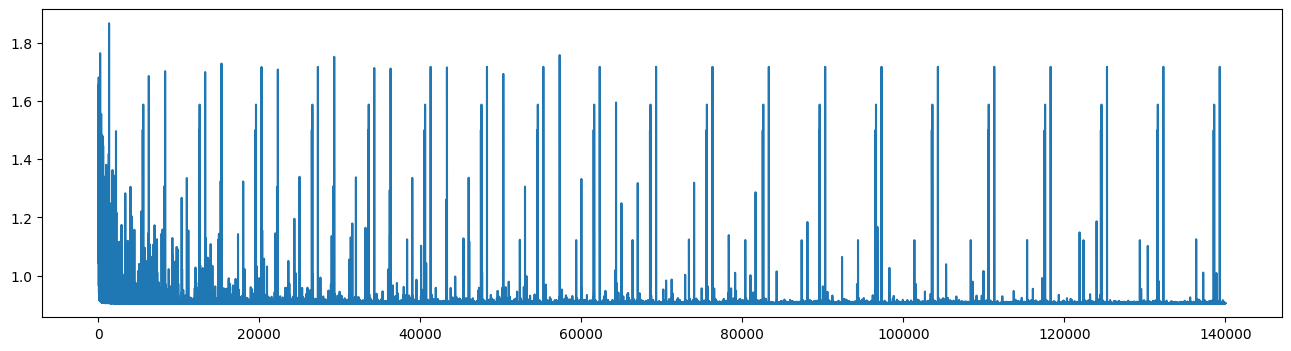

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(model.loss_history)

In [17]:
with torch.no_grad():
    train_predict = []
    train_proba = []
    for batch_X in train_tokens:
        predict = model(batch_X.to(device)).cpu()
        train_proba.append(predict[:, 1])
        train_predict.append(torch.argmax(predict, dim=1))
    
    train_predict = torch.cat(train_predict)
    train_proba = torch.cat(train_proba)
    train_real = torch.cat(train_labels)

    print(f'BA: {balanced_accuracy_score(train_real, train_predict):.3f}')
    print(f'F1: {f1_score(train_real, train_predict, average="micro"):.3f}')
    # print(f'ROC AUC: {roc_auc_score(train_real, train_proba):.3f}')

BA: 0.995
F1: 0.999


In [18]:
with torch.no_grad():
    valid_predict = []
    valid_proba = []
    for batch_X in valid_tokens:
        predict = model(batch_X.to(device)).cpu()
        valid_proba.append(predict[:, 1])
        valid_predict.append(torch.argmax(predict, dim=1))

    valid_predict = torch.cat(valid_predict)
    valid_proba = torch.cat(valid_proba)
    valid_real = torch.cat(valid_labels)

    print(f'BA: {balanced_accuracy_score(valid_real, valid_predict):.3f}')
    print(f'F1: {f1_score(valid_real, valid_predict, average="micro"):.3f}')
    # print(f'ROC AUC: {roc_auc_score(test_real, test_proba):.3f}')

BA: 0.958
F1: 0.999


In [25]:
columns = [
    'O',
    'STREET_ADDRESS',
    'USERNAME',
    'ID_NUM',
    # 'NAME_STUDENT',
]

pd.DataFrame(confusion_matrix(test_real, test_predict), columns=columns)

,O,STREET_ADDRESS,USERNAME,ID_NUM
0,1657550,0,0,0
1,7,5185,0,0
2,547,0,0,0
3,840,1,0,0


In [13]:
token2emb = []
train_tokens = []
train_labels = []
test_tokens = []
test_labels = []

gc.collect()

2126

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_weigths = torch.FloatTensor([1,1,1])
model = BiLSTM(
    embedding_dim=300,
    hidden_size=32,
    nclasses=len(class_weigths),
    device=device,
    class_weigths=class_weigths
)

checkpoint = torch.load('saved_models/bi_lstm_long.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.optim.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
model.to(device)
print()

In [5]:
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))


0it [00:00, ?it/s]

In [6]:
def get_predict_table(data, token2emb, num2label):
    def check_name(x):
        flag = False
        flag = x[0].isupper()
        for it in x[1:]:
            flag *= it.islower()
        return flag
    
    data_tokens, _ = embedding(data, token2emb)
    predict_table = [[], [], [], [], []] # document, token_idx, token, predict, real
    for i in tqdm(range(len(data))):
        with torch.no_grad():
            predict = torch.argmax(model.forward(data_tokens[i].to(device)), dim=1).cpu()
            predict = [num2label[it.item()] for it in predict]
            predict = ['O' if len(set(x)) < 2 else y for x, y in zip(data[i]['tokens'], predict)]
            predict_table[0] += [data[i]['document']]*len(predict)
            predict_table[1] += list(range(len(predict)))
            predict_table[2] += data[i]['tokens']
            predict_table[3] += predict
            predict_table[4] += data[i]['labels'] 
        
    predict_table = [[predict_table[0][i], predict_table[1][i], predict_table[2][i], predict_table[3][i], predict_table[4][i]] for i in range(len(predict_table[0]))]
    predict_table = pd.DataFrame(predict_table, columns=['document', 'token_i', 'token', 'predict', 'label'])
    predict_table = predict_table.loc[((predict_table.predict != 'O') | (predict_table.label != 'O')) & ((predict_table.token != "\n") | (predict_table.token != "\n\n") | (predict_table.token != "\t"))].reset_index(drop=True)
    predict_table['prefix'] = 'B-'

    predict_table['upper_start'] = predict_table.token.apply(check_name)
    predict_table = predict_table.loc[((predict_table.upper_start == 1) & (predict_table.predict == 'NAME_STUDENT')) | (predict_table.predict != 'NAME_STUDENT')].reset_index(drop=True)
    predict_table = predict_table.sort_values('document').reset_index(drop=True)

    return predict_table.loc[predict_table.label.isin(set(['O', 'B-ID_NUM', 'I-ID_NUM', 'B-USERNAME', 'I-USERNAME']))].reset_index(drop=True)

In [7]:
num2label = {
    0: 'O',
    1: 'NAME_STUDENT', 
    2: 'STREET_ADDRESS', 
    # 3: 'USERNAME',
    # 4: 'ID_NUM',
}

import gc
with open('data/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
predict_table = get_predict_table(data, token2emb, num2label)
gc.collect()

  0%|          | 0/6807 [00:00<?, ?it/s]

  0%|          | 0/6807 [00:00<?, ?it/s]

0

In [8]:
for i in range(1, predict_table.shape[0]):
    if (predict_table.at[i-1, 'predict'] == predict_table.at[i, 'predict']) & (predict_table.at[i-1, 'document'] == predict_table.at[i, 'document']) & (predict_table.at[i, 'token_i'] - predict_table.at[i-1, 'token_i'] == 1):
        predict_table.at[i, 'prefix'] = 'I-'
predict_table['predict'] = predict_table['prefix'] + predict_table['predict']

print(f'F1 score: {f1_score(predict_table.label, predict_table.predict, average="micro")}')

F1 score: 0.0


In [9]:
print(f'F1 score: {f1_score(predict_table.label, predict_table.predict, average="micro")}')

F1 score: 0.07253886010362694


In [9]:
predict_table.loc[predict_table.predict != predict_table.label].groupby('predict', as_index=False).label.count()

,predict,label
0,B-ID_NUM,76
1,B-NAME_STUDENT,733
2,B-O,3
3,B-STREET_ADDRESS,6
4,B-USERNAME,158
5,I-ID_NUM,1
6,I-NAME_STUDENT,95
7,I-STREET_ADDRESS,2
8,I-USERNAME,1
